# Mining Software Repositories(MSR) 2025 - Mining Challenge

# Research Question #1 (RQ1)

**Can we deduce the different clusters from the Maven Central's dependency graph, and how do these clusters interact with one another?**

# Cluster Identification

### Query Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json
import os
import seaborn as sns

In [3]:
# Increase the width to avoid content wrapping
pd.set_option('display.max_colwidth', None)  # Set to 'None' to avoid truncation
pd.set_option('display.width', 1000)  # Increase the display width (adjust based on your needs)
pd.set_option('display.max_columns', None)  # Display all columns in the dataframe

In [6]:
from neo4j import GraphDatabase

#connect to the database
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "Password1"))

In [8]:
def execute_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return result.data()

In [10]:
gds_version = """
CALL gds.version()
"""
print(execute_query(gds_version))

[{'gdsVersion': '2.6.8'}]


### Create Projected Graph

**Ensure the Graph is Fully Projected**  
The entire Maven Repository graph, including all Artifact and Release nodes

In [13]:
# Fetch all node property keys from the database
property_keys_query = """
CALL db.propertyKeys() YIELD propertyKey
RETURN collect(propertyKey) AS propertyKeys
"""
result = execute_query(property_keys_query)
property_keys = result[0]['propertyKeys']
print(f"Node property keys: {property_keys}")


Node property keys: ['id', 'found', 'version', 'timestamp', 'scope', 'targetVersion', 'type', 'value', 'communityId']


In [16]:
# Define the graph name
graph_name = 'mavenGraph'

# Check if the graph exists and drop it if it does
graph_exists_query = f"""
CALL gds.graph.exists('{graph_name}')
YIELD exists
"""
exists_result = execute_query(graph_exists_query)
if exists_result and exists_result[0]['exists']:
    drop_graph_query = f"""
    CALL gds.graph.drop('{graph_name}')
    YIELD graphName
    """
    execute_query(drop_graph_query)
    print(f"Existing graph '{graph_name}' has been dropped.")

# Project the graph without node properties
graph_projection_query = f"""
CALL gds.graph.project(
  '{graph_name}',
  ['Artifact', 'Release'],
  {{
    dependency: {{
      orientation: 'UNDIRECTED'
    }},
    relationship_AR: {{
      orientation: 'UNDIRECTED'
    }}
  }}
)
"""
execute_query(graph_projection_query)
print(f"Graph '{graph_name}' has been projected into GDS.")



Graph 'mavenGraph' has been projected into GDS.


### Checking Graph

**List node properties in the graph**

In [19]:
# Query to list node properties in the graph
node_properties_query = f"""
CALL db.labels()
"""
node_properties = execute_query(node_properties_query)
print("Node Properties:")
for row in node_properties:
    print(row)

Node Properties:
{'label': 'Artifact'}
{'label': 'Release'}
{'label': 'AddedValue'}


### Previously Saved Algorithms

In [21]:
leiden_results_file = 'Leiden_algorithm_results.json'

## Leiden

### Running the Leiden Algorithm

In [28]:
# Run the Leiden algorithm
leiden_algorithm_query = f"""
CALL gds.leiden.mutate('{graph_name}', {{
  mutateProperty: 'communityId'
}})
YIELD communityCount, modularity 
"""
leiden_results = execute_query(leiden_algorithm_query)
print(f"Leiden algorithm completed. Number of communities found: {leiden_results[0]['communityCount']}")

    

Leiden algorithm completed. Number of communities found: 67669


### Save Results for Future Analysis

In [31]:
    with open('Leiden_algorithm_results.json','w') as json_file:
        json.dump(leiden_results, json_file)
    print("Leiden algorithm results saved to 'Leiden_algorithm_results.json'")

Leiden algorithm results saved to 'Leiden_algorithm_results.json'


### Retreive Saved Results

In [34]:
with open('Leiden_algorithm_results.json', 'r') as json_file:
    leiden_cluster_results = json.load(json_file)

leiden_cluster_results_df = pd.DataFrame(leiden_cluster_results)
print(leiden_cluster_results_df.head(10))  # To verify the data


   communityCount  modularity
0           67669    0.704205


###### Modularity measures the density of links inside communities compared to links between communities. A high modularity score suggests that the nodes within a cluster are more densely connected to each other than nodes outside the cluster.  
**Modularity: 0.704205** suggerts a reasonably strong clustering, indicating that the Maven Central Repository has well-defined communities where dependencies are more prevalent within clusters than between them.

### Write Community Assignments Back to the Database

In [38]:
# Write the communityId back to the database
write_properties_query = f"""
CALL gds.graph.writeNodeProperties('{graph_name}', ['communityId'])
YIELD propertiesWritten
"""

write_results = execute_query(write_properties_query)
print(f"Node properties written back to the database: {write_results[0]['propertiesWritten']}")


Node properties written back to the database: 15117217


### Verify Community Assignments

In [41]:
# Verify the communityId property exists in the nodes
verify_query = f"""
MATCH (n)
WHERE n.communityId IS NOT NULL
RETURN n.communityId AS communityId, count(*) AS nodeCount
LIMIT 10
"""
verify_results = execute_query(verify_query)

# Print out a sample of the results
for result in verify_results:
    print(f"CommunityId: {result['communityId']}, Node Count: {result['nodeCount']}")


CommunityId: 28940, Node Count: 1632903
CommunityId: 30270, Node Count: 1028568
CommunityId: 43407, Node Count: 66
CommunityId: 48568, Node Count: 1073498
CommunityId: 26959, Node Count: 1795221
CommunityId: 10862, Node Count: 372129
CommunityId: 13965, Node Count: 550821
CommunityId: 13026, Node Count: 4
CommunityId: 657, Node Count: 59604
CommunityId: 27287, Node Count: 128003


### Get Properties Available in Database

In [44]:
# Query to get all node properties in the graph
all_properties_query = """
CALL db.schema.nodeTypeProperties()
YIELD nodeType, propertyName
RETURN nodeType, propertyName
ORDER BY nodeType, propertyName
"""
properties_results = execute_query(all_properties_query)

# Print out the node types and their properties
for result in properties_results:
    print(f"Node Type: {result['nodeType']}, Property Name: {result['propertyName']}")


Node Type: :`AddedValue`, Property Name: id
Node Type: :`AddedValue`, Property Name: type
Node Type: :`AddedValue`, Property Name: value
Node Type: :`Artifact`, Property Name: communityId
Node Type: :`Artifact`, Property Name: found
Node Type: :`Artifact`, Property Name: id
Node Type: :`Release`, Property Name: communityId
Node Type: :`Release`, Property Name: id
Node Type: :`Release`, Property Name: timestamp
Node Type: :`Release`, Property Name: version


## Analyze Top Clusters

### Examine Cluster Sizes and Basic Statistics

Identify how large each cluster is an how they compare to another.  
This provides context for their significance in the ecosystem.

In [49]:
# Query to get cluster sizes
cluster_sizes_query = f"""
MATCH (n)
WHERE n.communityId IS NOT NULL
RETURN n.communityId AS communityId, count(*) AS size
ORDER BY size DESC
LIMIT 10
"""
cluster_sizes = execute_query(cluster_sizes_query)
cluster_sizes_df = pd.DataFrame(cluster_sizes)
print("Top 10 Clusters by Size:")
print(cluster_sizes_df)


Top 10 Clusters by Size:
   communityId     size
0        26959  1795221
1        28940  1632903
2        29418  1293045
3        48568  1073498
4        30270  1028568
5        34416   775442
6        65609   613915
7        28947   561882
8        13965   550821
9        14097   458680


**Create a Bar Chart to Display Information**

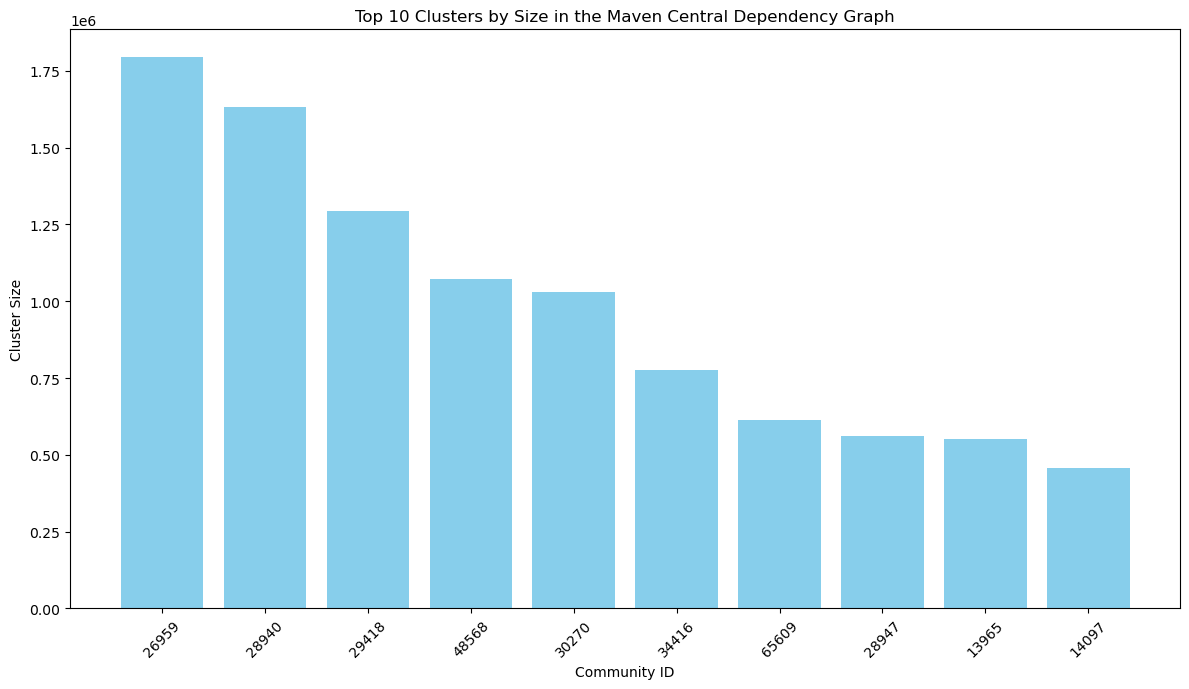

In [52]:
# Create a bar chart
plt.figure(figsize=(12, 7))
plt.bar(cluster_sizes_df['communityId'].astype(str), cluster_sizes_df['size'], color='skyblue')
plt.xlabel('Community ID')
plt.ylabel('Cluster Size')
plt.title('Top 10 Clusters by Size in the Maven Central Dependency Graph')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()       # Adjust layout to make room for labels
plt.show()



### Analyze All Clusters

In [55]:
# Query to get cluster sizes
cluster_sizes_query = f"""
MATCH (n)
WHERE n.communityId IS NOT NULL
RETURN n.communityId AS communityId, count(*) AS size
ORDER BY size DESC
"""
cluster_sizes_all = execute_query(cluster_sizes_query)
cluster_sizes_all_df = pd.DataFrame(cluster_sizes_all)
print("All Clusters Sorted by Size, only show top few:")
print(cluster_sizes_all_df.head(20))

All Clusters Sorted by Size, only show top few:
    communityId     size
0         26959  1795221
1         28940  1632903
2         29418  1293045
3         48568  1073498
4         30270  1028568
5         34416   775442
6         65609   613915
7         28947   561882
8         13965   550821
9         14097   458680
10        17717   439791
11        10862   372129
12        10471   368422
13        31276   348112
14        21652   317599
15        29205   253813
16        35373   177326
17        67551   168704
18        28969   129070
19        27287   128003


**Create a Scatter Plot to Show the Distribution of Cluster Sizes**

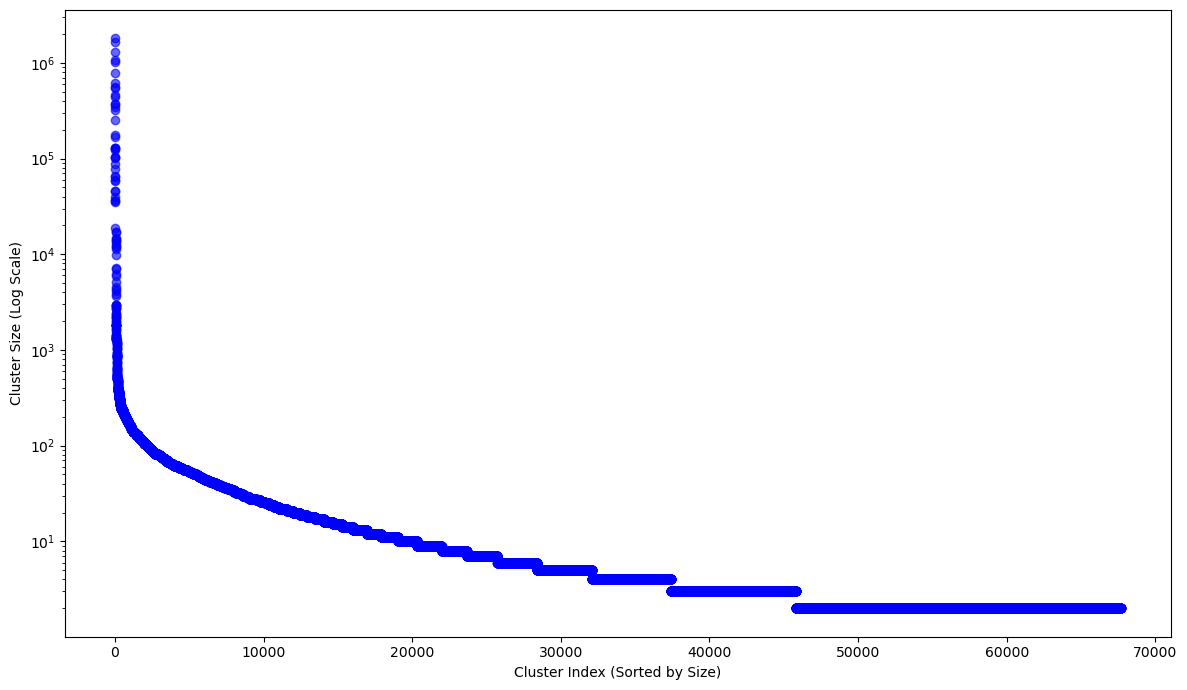

In [58]:
# Sort the clusters by size in descending order for a more intuitive distribution plot
cluster_sizes_all_df = cluster_sizes_all_df.sort_values(by='size', ascending=False)

# Create a scatter plot with a logarithmic y-axis
plt.figure(figsize=(12, 7))
plt.scatter(range(len(cluster_sizes_all_df)), cluster_sizes_all_df['size'], color='blue', alpha=0.6)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.xlabel('Cluster Index (Sorted by Size)')
plt.ylabel('Cluster Size (Log Scale)')
# plt.title('Distribution of Cluster Sizes in Maven Central (Logarithmic Scale)') # remove title for inclusion in paper
plt.tight_layout()


plt.savefig('cluster_size_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

**Use a Density Plot**

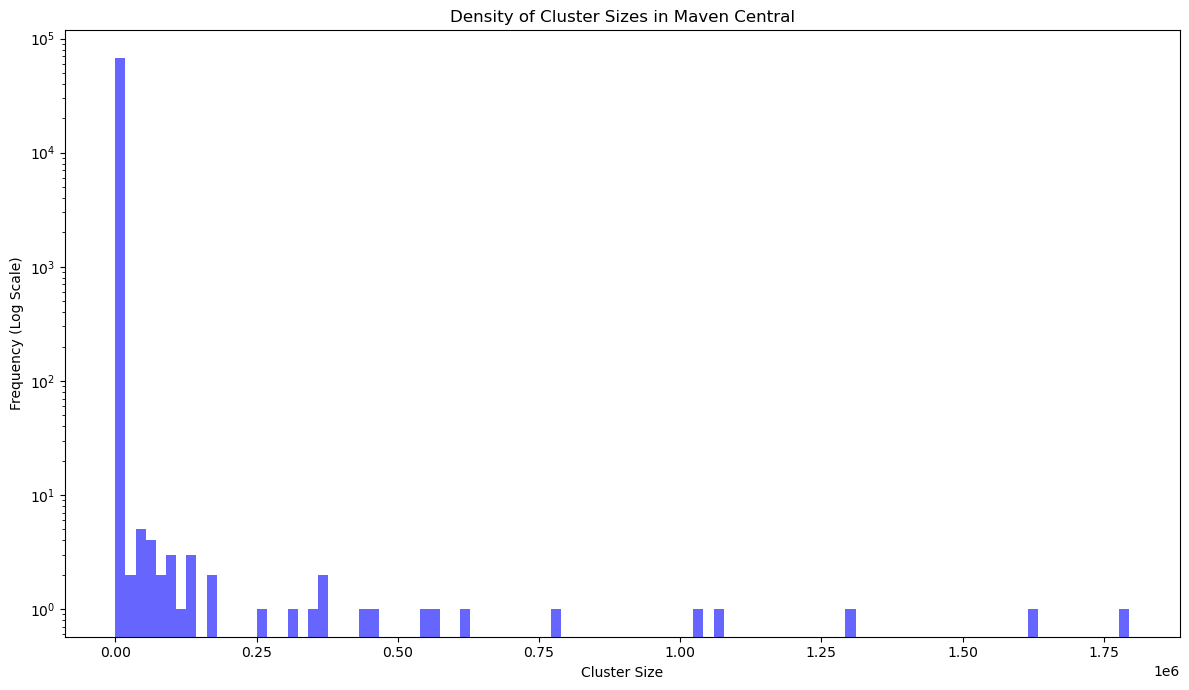

In [61]:
# Create a histogram with a logarithmic scale
plt.figure(figsize=(12, 7))
plt.hist(cluster_sizes_all_df['size'], bins=100, color='blue', alpha=0.6)
plt.yscale('log')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency (Log Scale)')
plt.title('Density of Cluster Sizes in Maven Central')
plt.tight_layout()
plt.show()

**Display as a KDE Plot**

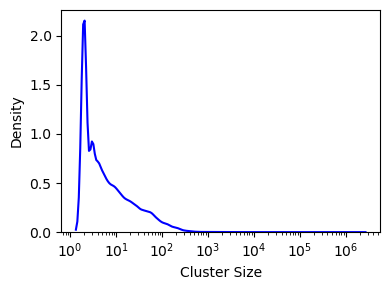

In [68]:
plt.figure(figsize=(4,3))
sns.kdeplot(cluster_sizes_all_df['size'], log_scale=True, color='blue')
plt.xlabel('Cluster Size')
plt.ylabel('Density')
# plt.title('Kernel Density Estimate of Cluster Sizes')
plt.tight_layout()
plt.savefig('cluster_size_KDE.pdf', bbox_inches='tight')
plt.show()

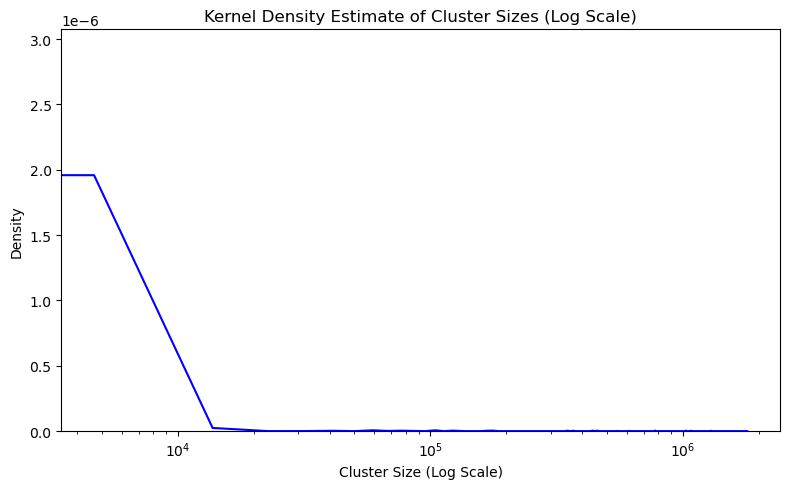

In [82]:
# Plotting the KDE plot with a logarithmic x-axis
plt.figure(figsize=(8, 5))
sns.kdeplot(cluster_sizes_all_df['size'], color='blue')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlabel('Cluster Size (Log Scale)')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Cluster Sizes (Log Scale)')
plt.tight_layout()
plt.show()

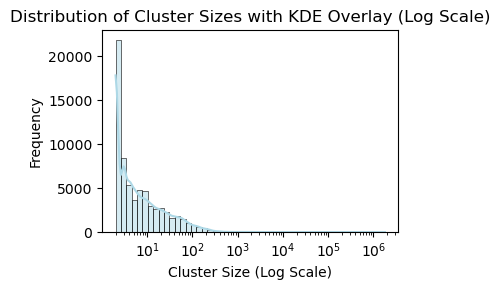

In [84]:
# Plotting a histogram with a KDE overlay
plt.figure(figsize=(4, 3))
sns.histplot(cluster_sizes_all_df['size'], bins=50, color='lightblue', kde=True, log_scale=(True, False))
plt.xscale('log')  # Use a logarithmic scale for the x-axis
plt.xlabel('Cluster Size (Log Scale)')
plt.ylabel('Frequency')
plt.title('Distribution of Cluster Sizes with KDE Overlay (Log Scale)')
plt.tight_layout()
plt.savefig('cluster_size_KDE_overlay.pdf', bbox_inches='tight')
plt.show()

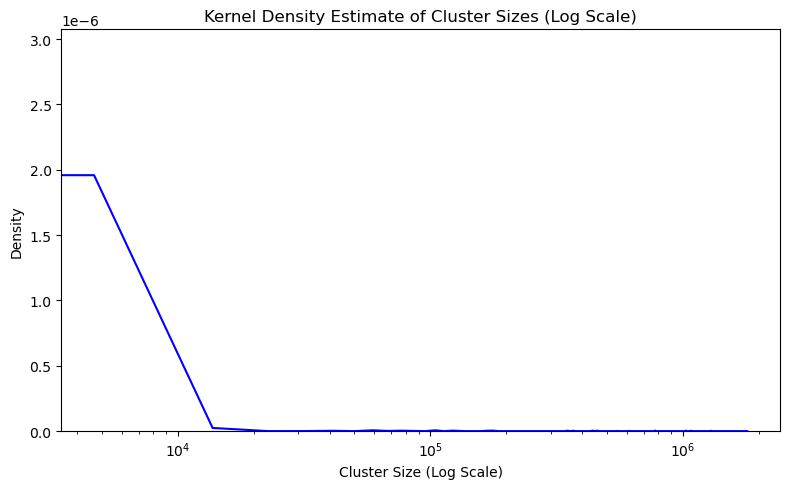

In [90]:
# Annotate the largest clusters
largest_clusters = cluster_sizes_all_df.sort_values(by='size', ascending=False).head(5)

plt.figure(figsize=(8, 5))
sns.kdeplot(cluster_sizes_all_df['size'], color='blue')
plt.xscale('log')
plt.xlabel('Cluster Size (Log Scale)')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Cluster Sizes (Log Scale)')

# Add annotations
for index, row in largest_clusters.iterrows():
    plt.annotate(f"ID: {row['communityId']}\nSize: {row['size']}",
                 xy=(row['size'], 0.02),  # Adjust the y-value for visibility
                 xytext=(row['size'], 0.1),
                 arrowprops=dict(arrowstyle="->", color='black'),
                 fontsize=8)

plt.tight_layout()
plt.show()

### Find Top Cluster IDs

In [73]:
# Define N - number of top clusters to analyze
N = 20  # Adjust N based on what your system can handle

# Query to get top N clusters by size
top_clusters_query = f"""
MATCH (n)
WHERE n.communityId IS NOT NULL
RETURN n.communityId AS communityId, count(*) AS size
ORDER BY size DESC
LIMIT {N}
"""
top_clusters = execute_query(top_clusters_query)
top_cluster_ids = [row['communityId'] for row in top_clusters]
print(f"Top {N} clusters: {top_cluster_ids}")

Top 20 clusters: [26959, 28940, 29418, 48568, 30270, 34416, 65609, 28947, 13965, 14097, 17717, 10862, 10471, 31276, 21652, 29205, 35373, 67551, 28969, 27287]


### Analyze Artifact Composition

Examine sample artifacts to infer the common themes or functionalities within each cluster.

In [75]:
# For each top cluster, sample artifacts
for cluster_id in top_cluster_ids:
    sample_artifacts_query = f"""
    MATCH (n)
    WHERE n.communityId = {cluster_id}
    RETURN labels(n) AS node_type, n.id AS name, n.version AS version
    LIMIT 10
    """
    artifacts = execute_query(sample_artifacts_query)
    artifacts_df = pd.DataFrame(artifacts)
    print(f"Sample artifacts from Cluster {cluster_id}:")
    print(artifacts_df)


Sample artifacts from Cluster 26959:
    node_type                                                      name             version
0  [Artifact]                         com.lihaoyi:ammonite-shell_2.10.5                None
1  [Artifact]                  com.codacy:codacy-engine-scala-seed_2.12                None
2   [Release]          com.codacy:codacy-engine-scala-seed_2.12:3.0.183             3.0.183
3   [Release]          com.lihaoyi:ammonite-shell_2.10.5:COMMIT-38f6574      COMMIT-38f6574
4  [Artifact]                     io.janstenpickle:trace4cats-meta_2.13                None
5   [Release]  io.janstenpickle:trace4cats-meta_2.13:0.7.0+168-2ce97ef2  0.7.0+168-2ce97ef2
6  [Artifact]                       dev.zio:zio-aws-resourcegroups_2.12                None
7   [Release]            dev.zio:zio-aws-resourcegroups_2.12:5.17.233.1          5.17.233.1
8  [Artifact]          org.hawkular.metrics:hawkular-metrics-load-tests                None
9  [Artifact]                   ch.epfl.lam

### Analyze Inter-Cluster Relationships

* Identify which clusters have the most dependencies between them
* Understand the strength and directionality of the interactions.

In [77]:
# Query to analyze inter-cluster relationships
inter_cluster_query = f"""
MATCH (a)-[r]->(b)
WHERE a.communityId <> b.communityId
RETURN a.communityId AS sourceCluster, b.communityId AS targetCluster, count(*) AS connections
ORDER BY connections DESC
LIMIT 10
"""
inter_cluster_connections = execute_query(inter_cluster_query)
inter_cluster_df = pd.DataFrame(inter_cluster_connections)
print("Top 10 Inter-Cluster Connections:")
print(inter_cluster_df)


Top 10 Inter-Cluster Connections:
   sourceCluster  targetCluster  connections
0          48568          29418      1791786
1          29418          48568      1447774
2          34416          29418       837511
3          34416          28947       711388
4          29418          28947       699461
5          26959          29418       502251
6          13965          29418       451899
7          30270          29418       451654
8          65609          29418       450349
9          48568          28947       450185


### Export Data for Visualization

In [80]:
# Convert cluster IDs to a string for Cypher query
cluster_ids_string = ', '.join(map(str, top_cluster_ids))

# Query to get nodes in top clusters
nodes_export_query = f"""
MATCH (n)
WHERE n.communityId IN [{cluster_ids_string}]
RETURN id(n) AS nodeId, labels(n) AS labels, n.id AS name, n.communityId AS communityId
"""
nodes = execute_query(nodes_export_query)
nodes_df = pd.DataFrame(nodes)
print(f"Exported {len(nodes_df)} nodes from top {N} clusters.")

Exported 12486944 nodes from top 20 clusters.


In [86]:
# Save to JSON
nodes_df.to_json('nodes_top_clusters.json', orient='records', lines=False)
print("Nodes have been saved to 'nodes_top_clusters.json'.")


Nodes have been saved to 'nodes_top_clusters.json'.


### Explore Bidirectional Connections

In [88]:
# Query to identify bidirectional inter-cluster connections
bidirectional_query = f"""
MATCH (a)-[r1]->(b), (b)-[r2]->(a)
WHERE a.communityId <> b.communityId
RETURN a.communityId AS sourceCluster, b.communityId AS targetCluster, 
       count(r1) + count(r2) AS totalConnections
ORDER BY totalConnections DESC
LIMIT 10
"""
bidirectional_connections = execute_query(bidirectional_query)
bidirectional_df = pd.DataFrame(bidirectional_connections)
print("Top 10 Bidirectional Inter-Cluster Connections:")
print(bidirectional_df)

Top 10 Bidirectional Inter-Cluster Connections:
   sourceCluster  targetCluster  totalConnections
0          26959          48568                56
1          48568          26959                56
2          10862          28947                34
3          28947          10862                34
4          29418          35373                18
5          35373          29418                18
6          48568          28940                10
7          28940          48568                10
8          29418          65609                 8
9          65609          29418                 8


### Investigate Inter-Cluster Interactions

**Visualize Inter-Cluster Relationships**

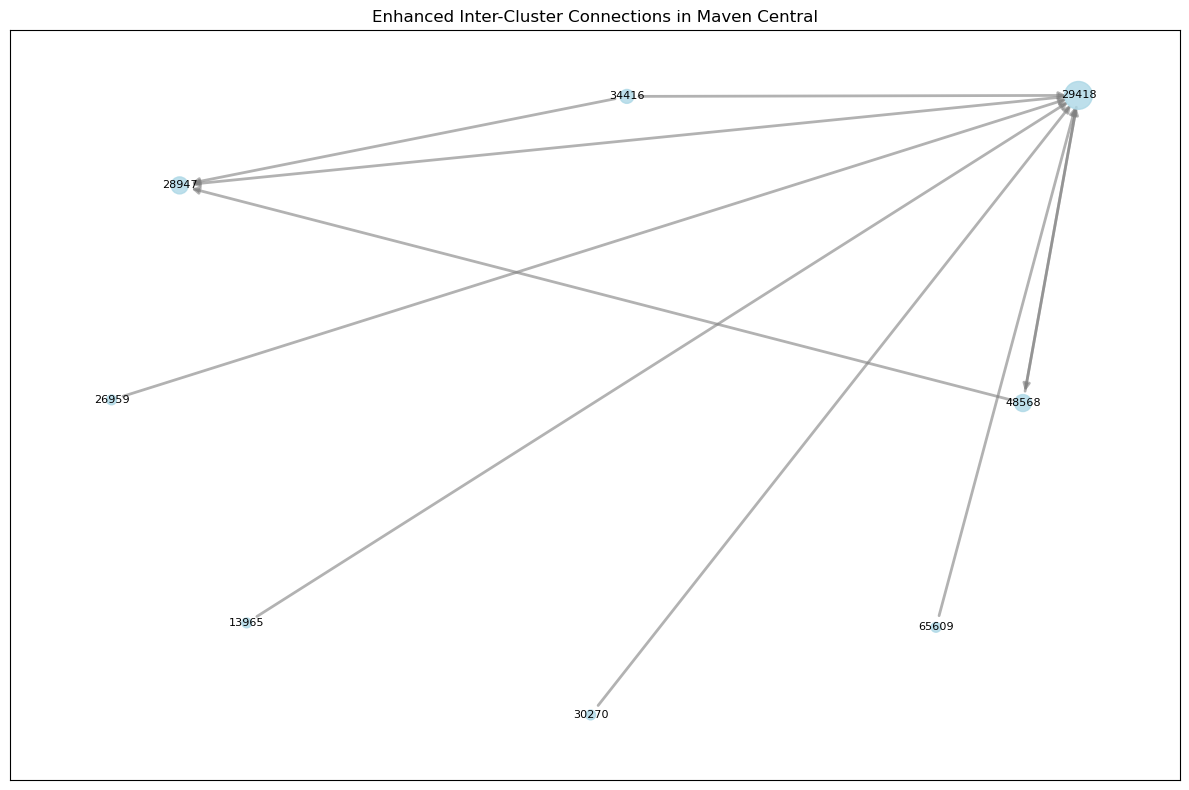

In [92]:
# Create a directed graph
G = nx.DiGraph()

# Add a subset of nodes and edges for clarity
for index, row in inter_cluster_df.iterrows():
    G.add_edge(row['sourceCluster'], row['targetCluster'], weight=row['connections'])

# Use Kamada-Kawai layout for a more evenly distributed graph
pos = nx.kamada_kawai_layout(G)

# Scale node sizes by the degree of each node
node_sizes = [G.degree(node) * 50 for node in G.nodes()]

# Draw the graph with customized settings
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.title("Enhanced Inter-Cluster Connections in Maven Central")
plt.tight_layout()
plt.show()


**Heatmap for Connection Strenghts**

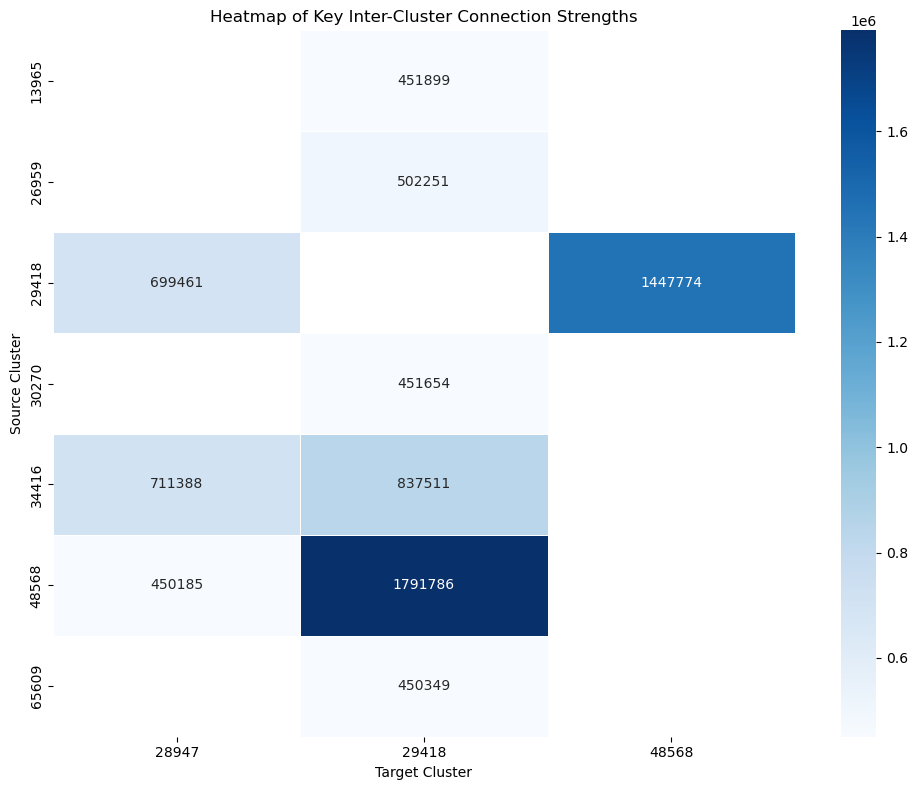

In [94]:
# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = inter_cluster_df.pivot(index="sourceCluster", columns="targetCluster", values="connections")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5)
plt.title("Heatmap of Key Inter-Cluster Connection Strengths")
plt.xlabel("Target Cluster")
plt.ylabel("Source Cluster")
plt.tight_layout()
plt.show()


**Identify Bridge Nodes - Releases**

In [96]:
# Query to find bridge nodes (artifacts/release nodes connecting clusters)
bridge_nodes_query = f"""
MATCH (a)-[r:dependency]->(b)
WHERE a.communityId IS NOT NULL AND b.communityId IS NOT NULL AND a.communityId <> b.communityId
RETURN a.id AS bridgeRelease, a.communityId AS sourceCluster, b.communityId AS targetCluster, count(r) AS connectionCount
ORDER BY connectionCount DESC
LIMIT 100
"""

# Execute the query
bridge_nodes = execute_query(bridge_nodes_query)
bridge_nodes_df = pd.DataFrame(bridge_nodes)

# Display the results
print("Top 30 Bridge Nodes Between Clusters:")
print(bridge_nodes_df)


Top 30 Bridge Nodes Between Clusters:
                                                            bridgeRelease  sourceCluster  targetCluster  connectionCount
0                                     org.apache.camel:apache-camel:3.0.0          48568          13965              311
1                                     org.apache.camel:apache-camel:3.0.1          48568          13965              311
2                                  io.hyte.platform:repo:4.3.7.hyte-4307e          10862          13965              121
3                                  io.hyte.platform:repo:4.3.7.hyte-4307a          10862          13965              121
4                                  io.hyte.platform:repo:4.3.7.hyte-43073          10862          13965              121
..                                                                    ...            ...            ...              ...
95                              it.agilelab:wasp-model_2.11:2.32.0-cdp717          10862          26959            

**Identify Bridge Nodes - Artifacts**

In [98]:
# Extract the artifact name from the bridgeRelease string
bridge_nodes_df['artifactId'] = bridge_nodes_df['bridgeRelease'].str.split(':').str[0]

# Display the updated DataFrame
print("Updated DataFrame with Artifact Names:")
print(bridge_nodes_df[['bridgeRelease', 'artifactId']])


Updated DataFrame with Artifact Names:
                                                            bridgeRelease                         artifactId
0                                     org.apache.camel:apache-camel:3.0.0                   org.apache.camel
1                                     org.apache.camel:apache-camel:3.0.1                   org.apache.camel
2                                  io.hyte.platform:repo:4.3.7.hyte-4307e                   io.hyte.platform
3                                  io.hyte.platform:repo:4.3.7.hyte-4307a                   io.hyte.platform
4                                  io.hyte.platform:repo:4.3.7.hyte-43073                   io.hyte.platform
..                                                                    ...                                ...
95                              it.agilelab:wasp-model_2.11:2.32.0-cdp717                        it.agilelab
96  org.ops4j.pax.web.itest.container:pax-web-itest-container-jetty:7.4.1  org.ops4j.pax.

In [199]:
# Extract unique artifact names
unique_artifacts = bridge_nodes_df['artifactId'].unique()

# Display the unique artifacts
print("Unique Artifacts:")
print(unique_artifacts)


Unique Artifacts:
['org.apache.camel' 'org.opendaylight.controller'
 'org.ops4j.pax.web.itest' 'io.hyte.platform' 'org.springframework.boot'
 'it.agilelab' 'org.ops4j.pax.web.itest.container']


### Analyzing Dependency Depth Within Clusters

Find the **depth of dependencies** within each cluster.  
This query checks how deep the dependency chains are withing a cluster by identifying how many layers of dependencies exist between artifacts and releases in the same cluster.  
It looks for paths where one node depends on another, then counts how many dependencies exist along these paths.

In [101]:
# Define the query to get the depth of dependencies within each cluster
dependency_depth_query = f"""
MATCH (a)-[r:dependency*]->(b)
WHERE a.communityId = b.communityId
RETURN a.communityId AS communityId, count(r) AS depth
ORDER BY depth DESC
LIMIT 10
"""

# Execute the query
dependency_depths = execute_query(dependency_depth_query)
dependency_depths_df = pd.DataFrame(dependency_depths)

# Display the results
print("Top 10 Clusters by Dependency Depth:")
print(dependency_depths_df)


Top 10 Clusters by Dependency Depth:
   communityId     depth
0        48568  12861797
1        28947  10854528
2        26959   9834289
3        28940   9260035
4        29418   7225837
5        30270   5809257
6        34416   4762365
7        65609   4384609
8        14097   2613033
9        10471   2368639


**Deeper dependency chains** suggest that the cluster is more complex, with artifacts depending on multiple layers of other artifacts. 

**Complex clusters can be harder to manage, update, or refactor since changes to one artifact might ripple through the entire chain of dependencies, increasing maintenance cost and risks.**

### Analyzing Age of Artifacts in Clusters

Older dependencies could signal technical debt or clusters at risk for security vulnerabilities. Analyzing the age of artifacts within a cluster gives insight into how frequently the dependencies are updated.

In [104]:
# Define the query to get the age of artifacts in each top cluster
artifact_age_query = f"""
MATCH (n)
WHERE n.communityId IN {top_cluster_ids}
RETURN n.communityId AS communityId, n.id AS artifact_id, n.timestamp AS release_date
ORDER BY n.timestamp ASC
LIMIT 100
"""

# Execute the query
artifact_ages = execute_query(artifact_age_query)
artifact_ages_df = pd.DataFrame(artifact_ages)

# Convert the timestamp into readable dates if necessary
artifact_ages_df['release_date'] = pd.to_datetime(artifact_ages_df['release_date'], unit='ms')

# Display the results
print("Artifact ages in top clusters:")
print(artifact_ages_df.head(10))


Artifact ages in top clusters:
   communityId                       artifact_id        release_date
0        21652       org.jdom:jaxen-core:1.0-FCS 2002-05-15 04:32:34
1        21652          org.jdom:saxpath:1.0-FCS 2002-05-15 04:32:34
2        29418       com.toedter:jcalendar:1.1.4 2002-07-17 22:45:02
3        30270                xalan:xalan:2.5.D1 2003-03-02 20:33:39
4        48568           xmlpull:xmlpull:1.1.3.1 2003-06-17 00:03:58
5        14097         com.micheldalal:x10:1.0.1 2003-10-21 14:31:42
6        29418  com.incors.plaf:kunststoff:2.0.2 2004-07-07 01:00:56
7        21652       org.jdom:jaxen-jdom:1.0-FCS 2004-09-03 06:14:48
8        21652            com.caucho:resin:3.0.9 2004-10-02 22:52:42
9        21652               sslext:sslext:1.2-0 2004-10-03 20:10:42


## Close Projected Graph

In [107]:
with driver.session() as session:
    session.run("CALL gds.graph.drop('mavenGraph')")